In [2]:
"""
Create a ring of objects representing theoretical populations of objects in the distant solar system.

When run as a script, uses CFEPS survey characterization, runs until 28 sources have been detected in this ring and plots the result.
"""
from ossssim.models import Parametric
from ossssim import OSSSSim, DetectFile, ModelFile, definitions, plotter
from astropy import units


class Ring(Parametric):
    """
    Class used to create and store the objects generated and passed by the GiMeObj module into the main Driver.py
    module that executes the survey simulator code.
    """
    def __init__(self, ring_centre, ring_width, **kwargs):
        """Build a ring distribution of given with at a given distance.  Ring is edge-on and circular.

        Args:
            ring_center (units.Quantity): The location of the ring, given as unit quantity
            ring_width (units.Quantity): Width of the ring.
        """
        super().__init__(**kwargs)
        self.ring_center = ring_centre
        self.ring_width = ring_width


    @property
    def a(self):
        """
        Semi-major axis distribution for a narrow ring
        """
        return self.distributions.normal(self.ring_center.to('au').value,
                                         self.ring_width.to('au').value) * units.au



    @property
    def e(self):
        """
        Eccentricity axis distribution for a narrow ring
        """
        return self.distributions.constant(0.0)

    @property
    def inc(self):
        """
        Inclination distribution for a narrow ring
        """
        return self.distributions.constant(0.0) * units.rad

In [3]:
def run(model_filename,
        detect_filename,
        characterization_directory, seed, ntrack):
    """
    Using the ParametricModel defined here run the survey simulator and save detected sources to detect_filename

    Args:
        model_filename (str): Name of file to store the model targets.
        detect_filename (str): Name of file to store detected targets.
        characterization_directory (str): Relative or absolute path to directory on disk where the characterization files are organized
        seed (int): random number seed, specifying allows reproducibility
        ntrack (int): < 0 continue for ntrack iterations;
                      > 0 continue until n_tracked tracked detections;
                      = 0 continue until input exhausted
    """
    ssim = OSSSSim(characterization_directory=characterization_directory)

    # the default Resonant class arguments setup for a Plutino model....
    model = Ring(45*units.au, 1*units.au, seed=seed, component='Ring')

    model_file = DetectFile(model_filename)
    model_file.epoch = model.epoch
    model_file.longitude_neptune =model.longitude_neptune
    model_file.colors = definitions.COLORS.values()
    model_file.write_header(seed)

    detect_file = DetectFile(detect_filename)
    detect_file.epoch = model.epoch
    detect_file.longitude_neptune = model.longitude_neptune
    detect_file.colors = definitions.COLORS.values()
    detect_file.write_header(seed)

    n_iter = n_track = n_hits = 0
    for row in model:
        n_iter += 1
        result = ssim.simulate(row, seed=model.seed)
        model_file.write_row(result)
        if result['flag'] > 0:
            n_hits += 1
            detect_file.write_row(result)
        if result['flag'] > 2:
            n_track += 1
        if (0 < ntrack < n_track) or (0 < -ntrack < n_iter):
            break

    detect_file.write_footer(n_iter=n_iter, n_hits=n_hits, n_track=n_track)
    model_file.write_footer(n_iter=n_iter,
                            n_hits=n_hits,
                            n_track=n_track)

In [4]:
def face_down_plot(model_file: str, detect_file: str) -> None:
    """_
    Plot the detected objects in a face-down plot
    Args:
        detect_file: name of file with the detected sources
    """
    plot = plotter.RosePlot(definitions.Neptune['Longitude'])
    plot.add_model(ModelFile(model_file), mc='k', ms=0.05, alpha=0.1)
    plot.add_model(ModelFile(detect_file), ms=5, mc='g')
    # plot.add_scale_rings()
    plot.show()

In [5]:
run('RingModel.dat', 'RingDetect.dat', '../tests/data/CFEPS', 123456789, 28)

/Users/kavelaarsj/.pyenv/versions/3.9.1/Python.framework/Versions/3.9/lib/python3.9/site-packages/ossssim/plotter.py:143: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax1.set_xticklabels(x_tick_labels, color='b', alpha=0.6)


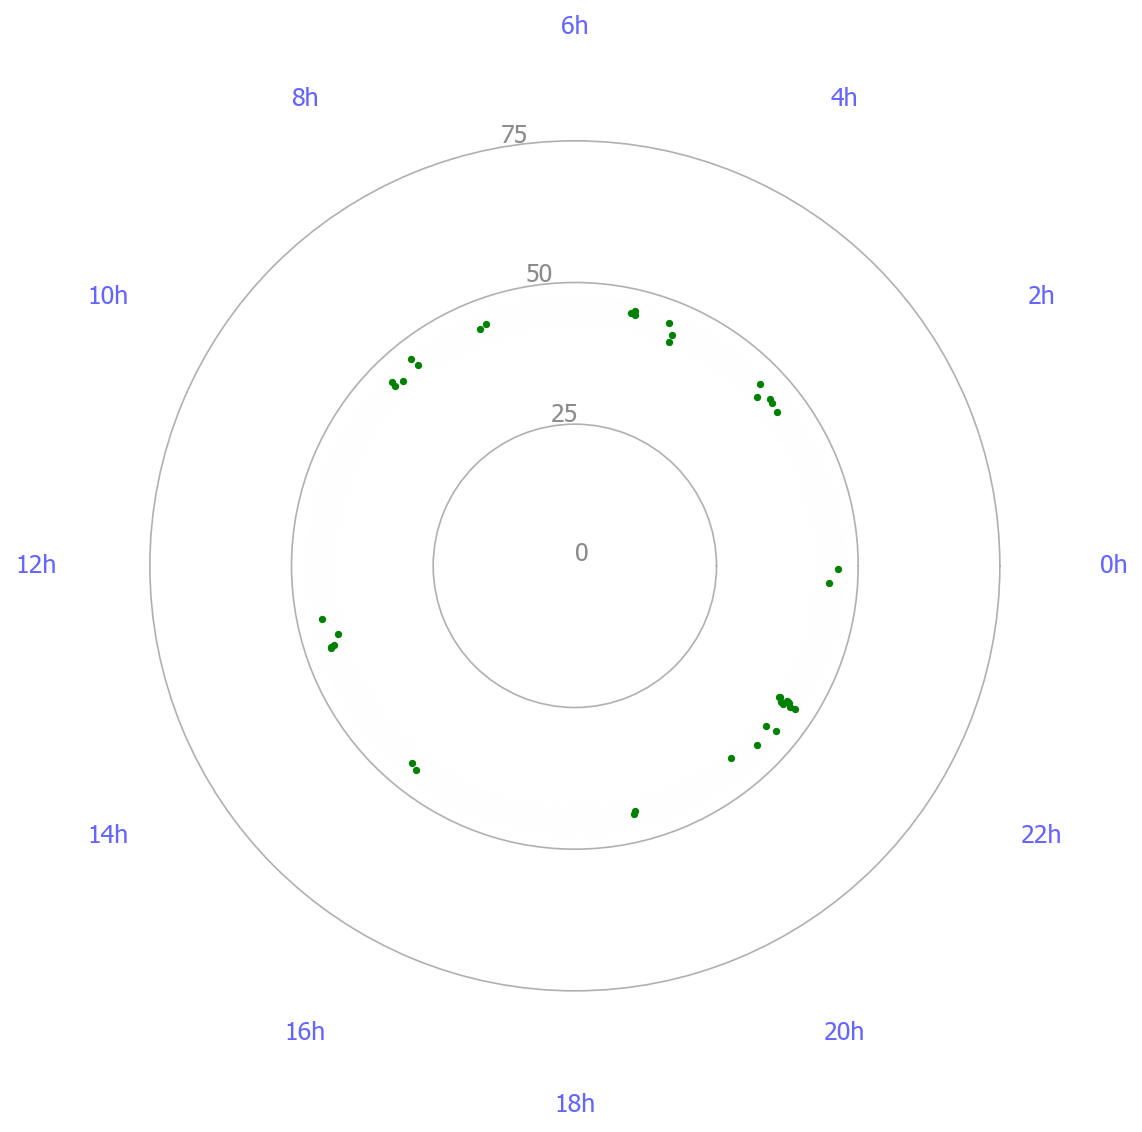

In [6]:
face_down_plot('RingModel.dat', 'RingDetect.dat')